## Исследование данных о российском кинопрокате



<b>Цель исследования:</b>
<br/>
Заказчик исследования — Министерство культуры Российской Федерации. 
Необходимо изучить рынок российского кинопроката и выявить текущие тренды. Также, требуется ответить на вопрос: интересны ли зрителю фильмы, получившие господдержку.
<br/>
<br/>
<b>Ход исследования:</b>
<br/>
Информация для анализа получена с портала открытых данных Министерства культуры. Набор данных содержит информацию о прокатных удостоверениях, сборах и государственной поддержке фильмов, а также информацию с сайта КиноПоиск. Исходные данные состоят из нескольких таблиц, которые потребуется объединить. Также, для анализа потребуется вычислить дополнительную информацию: год проката, имя и фамиля главного режиссёра, основной жанр фильма, доля господдержки в бюджете фильма.
<br/>
<br/>
Этапы исследования:
* Объединение данных.
* Обзор данных.
* Предобработка данных.
* Дополнение данных информацией, необходимой для дальнейшего анализа.
* Анализ динамики кинопроката.
* Анализ влияния возрастных ограничений на сборы.
* Анализ успешности фильмов с господдержкой.
* Общий вывод.

### Шаг 1. Откройте файлы с данными и объедините их в один датафрейм. 

Объедините данные таким образом, чтобы все объекты из датасета `mkrf_movies` обязательно вошли в получившийся датафрейм. 

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_0" aria-expanded="false" aria-controls="collapseHint_0">Подсказка</button>
        </div>
        <div id="collapseHint_0" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на тип данных столбца, по которому будете соединять датафреймы. Тип данных этих столбцов должен быть одинаковым в обоих датафреймах.
            </div>
        </div>
    </div>
</div>

In [1]:
import pandas as pd
import numpy as np

movies = pd.read_csv('/datasets/mkrf_movies.csv')
shows = pd.read_csv('/datasets/mkrf_shows.csv')

#Необходимо проверить колонки, по которым будет объединение:
print('movies: type:', movies['puNumber'].dtype.name, ', количество:', movies['puNumber'].count(), ', пустые:', movies['puNumber'].isna().sum())
print('shows: type:', shows['puNumber'].dtype.name, ', количество:', shows['puNumber'].count(), ', пустые:', shows['puNumber'].isna().sum())

movies: type: object , количество: 7486 , пустые: 0
shows: type: int64 , количество: 3158 , пустые: 0


In [2]:
#С пустотами в shows проблем нет
#Но в movies тип puNumber - object. Необходимо выяснить, почему не int
movies.sort_values('puNumber')['puNumber'].unique()

array([' 111004112', '111000110', '111000111', ..., '231001012',
       '231001111', 'нет'], dtype=object)

In [3]:
#'Нет' можно конвертировать в '0', но нужно убедиться, что в shows нет такого номера 
print(shows.query('puNumber == 0')['puNumber'].count())
#и что "Нет" в одном экземпляре:
movies.query('puNumber == "нет"')['puNumber'].count()

0


1

In [4]:
#'Нет' конвертировать в '0'. 
#Убрать пробелы в значениях.
#После этого можно конвертировать в int.
def fix_pu_number(pu_number):
    if (pu_number == 'нет'):
        return 0;
    return pu_number.strip();

movies['puNumber'] = movies['puNumber'].apply(fix_pu_number).astype('int');

In [5]:
#В shows точно есть данные не по всем фильмам. 
#Поэтому, после объединения, часть данных по сборам будет пустой.
#Данные по сборам фильмов, которые не вошли в movies, можно отбросить.
data = movies.merge(shows, how='left', on='puNumber')

In [6]:
#Проверка того, что данные из movies не были повреждены при слиянии:
print('Изменения в исходных данных movies: ')
data.drop('box_office', axis=1).compare(movies)

#Проверка того, что все данные из shows перенеслись в data:
shows_numbers = shows['puNumber']
print('Всего значений box_office: ', shows_numbers.count())
print('Перенесено значений box_office:', data.query('puNumber in @shows_numbers')['box_office'].notna().sum())

Изменения в исходных данных movies: 
Всего значений box_office:  3158
Перенесено значений box_office: 3158


In [7]:
data = data.rename(columns={ 'puNumber': 'pu_number' })

### Шаг 2. Предобработка данных

#### Шаг 2.1. Проверьте типы данных

- Проверьте типы данных в датафрейме и преобразуйте их там, где это необходимо.

In [8]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   title                  7486 non-null   object 
 1   pu_number              7486 non-null   int64  
 2   show_start_date        7486 non-null   object 
 3   type                   7486 non-null   object 
 4   film_studio            7468 non-null   object 
 5   production_country     7484 non-null   object 
 6   director               7477 non-null   object 
 7   producer               6918 non-null   object 
 8   age_restriction        7486 non-null   object 
 9   refundable_support     332 non-null    float64
 10  nonrefundable_support  332 non-null    float64
 11  budget                 332 non-null    float64
 12  financing_source       332 non-null    object 
 13  ratings                6519 non-null   object 
 14  genres                 6510 non-null   object 
 15  box_

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
0,Открытый простор,221048915,2015-11-27T12:00:00.000Z,Художественный,"Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикче...",США,Кевин Костнер,"Дэвид Валдес, Кевин Костнер, Джейк Эбертс",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,7.2,"боевик,драма,мелодрама",NaN
1,Особо важное задание,111013716,2016-09-13T12:00:00.000Z,Художественный,"Киностудия ""Мосфильм""",СССР,Е.Матвеев,NaN,«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,6.6,"драма,военный",NaN
2,Особо опасен,221038416,2016-10-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
3,Особо опасен,221026916,2016-06-10T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN
4,Особо опасен,221030815,2015-07-29T12:00:00.000Z,Художественный,"Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Пл...",США,Тимур Бекмамбетов,"Джим Лемли, Джейсон Нетер, Марк Е.Платт, Яйн Смит",«18+» - запрещено для детей,NaN,NaN,NaN,NaN,6.8,"фантастика,боевик,триллер",NaN


In [9]:
#Почти все 'object' поля - категориальные и изменять их тип нет необходимости.
#А вот поле 'show_start_date' стоит конвертировать в дату для облегчения дальнейшей работы с ним
data['show_start_date'] = pd.to_datetime(data['show_start_date'], format='%Y-%m-%dT%H:%M:%S.%fZ')

#### Шаг 2.2. Изучите пропуски в датафрейме

- Объясните, почему заполнили пропуски определённым образом или почему не стали этого делать.

In [10]:
#Есть много пропусков в категориальных строковых данных. 
#Такие пропуски можно заполнить значением 'Неизвестно': 
#таким образом, данные не потеряются при анализе и попадут в отдельную категорию
data = data.fillna({
    'director': 'Неизвестно',
    'producer': 'Неизвестно',
    'film_studio': 'Неизвестно',
    'genres': 'Неизвестно',
    'production_country': 'Неизвестно'
})
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7486 entries, 0 to 7485
Data columns (total 16 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   title                  7486 non-null   object        
 1   pu_number              7486 non-null   int64         
 2   show_start_date        7486 non-null   datetime64[ns]
 3   type                   7486 non-null   object        
 4   film_studio            7486 non-null   object        
 5   production_country     7486 non-null   object        
 6   director               7486 non-null   object        
 7   producer               7486 non-null   object        
 8   age_restriction        7486 non-null   object        
 9   refundable_support     332 non-null    float64       
 10  nonrefundable_support  332 non-null    float64       
 11  budget                 332 non-null    float64       
 12  financing_source       332 non-null    object        
 13  rat

Также, есть пустоты в колонках 'refundable_support', 'nonrefundable_support', 'budget', 'financing_source': это данные по госфинансированию. Такие пустоты заполнять не следует, чтобы в анализ по господдержке не попали фильмы без господдержки.

Пустоты в 'box_office' и 'ratings' могут иметь физический смысл (например, фильм не показывался в театрах, а вышел только в цифре), поэтому их заполнять не стоит.

#### Шаг 2.3. Изучите дубликаты в датафрейме
- Проверьте, есть ли в данных дубликаты. Опишите причины, которые могли повлиять на появление дублей.

In [11]:
print('Явные дубликаты:', data.duplicated().sum())
data = data.drop_duplicates()

Явные дубликаты: 0


In [12]:
#Дубликаты по названиям искать нет смысла - потому что по одному фильму может быть несколько 
#номеров прокатных удостоверений.
#Зато можно проверить дубли в номерах ПУ:
duplicated_pu_numbers = data[data['pu_number'].duplicated()]['pu_number']
print('Дубликаты идентификаторов:', duplicated_pu_numbers.count())

Дубликаты идентификаторов: 2


In [13]:
data.query('pu_number in @duplicated_pu_numbers')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
4638,Как жениться и остаться холостым,221154310,2010-12-17 12:00:00,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.0,"мелодрама,комедия",NaN
4639,Иоанна - женщина на папском престоле /По роман...,221154310,2010-12-17 12:00:00,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.6,"драма,мелодрама,история",NaN
5067,Анализируй это!,221054410,2010-05-25 12:00:00,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.4,"комедия,криминал",NaN
5068,Анализируй то!,221054410,2010-05-25 12:00:00,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.8,"комедия,криминал",NaN


In [14]:
titles = data.query('pu_number in @duplicated_pu_numbers')['title'].unique()
data.query('title in @titles').sort_values('title')

,title,pu_number,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
5068,Анализируй то!,221054410,2010-05-25 12:00:00,Художественный,"Уорнер Бразерс, Виллидж Роадшоу Пикчерз, Эн-Пи...",США,Гарольд Реймис,"Джейн Розенталь, Паул Уэйнстейн",«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,6.8,"комедия,криминал",NaN
4553,Анализируй это!,221147310,2010-12-15 12:00:00,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.4,"комедия,криминал",NaN
5067,Анализируй это!,221054410,2010-05-25 12:00:00,Художественный,"Уорнер Бразерс, Вилладж Роудшоу Филмз ЛТД",США-Австралия,ХЭрольд Рэмис,"Джейн Розенталь, Пола Уейнстейн",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.4,"комедия,криминал",NaN
4050,Иоанна - женщина на папском престоле /По роман...,121005410,2010-03-25 12:00:00,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.6,"драма,мелодрама,история",NaN
4513,Иоанна - женщина на папском престоле /По роман...,221141710,2010-12-03 12:00:00,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.6,"драма,мелодрама,история",NaN
4639,Иоанна - женщина на папском престоле /По роман...,221154310,2010-12-17 12:00:00,Художественный,"Константин Фильм, А Эр Ди Дегето Фильм, Дюне ...",Германия - Великобритания - Италия - Испания,Зенке Вортманн,"Оливер Бербен, Дорис Д.Хайнце, Фарук Элтан",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.6,"драма,мелодрама,история",NaN
4520,Как жениться и остаться холостым,221142510,2010-12-03 12:00:00,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.0,"мелодрама,комедия",NaN
4638,Как жениться и остаться холостым,221154310,2010-12-17 12:00:00,Художественный,"Ше Вам, Скрипт Ассосье, Тэ Фэ 1 Фильм Продюксь...",Франция,Эрик Лартиго,"Амандин Било, Алан Шаба",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.0,"мелодрама,комедия",NaN


In [15]:
#'Анализируй то!' встречается один раз, поэтому можно удалить 'Анализируй это!' с номером 221054410.
#'Иоанна - женщина' встречается трижды, поэтому ее и стоит удалить
data = data.drop([5067, 4639])

In [16]:
#ну и теперь можно номера использовать в качестве индексов
data = data.set_index('pu_number')

#### Шаг 2.4. Изучите категориальные значения

- Посмотрите, какая общая проблема встречается почти во всех категориальных столбцах;
- Исправьте проблемные значения в поле `type`.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_1" aria-expanded="false" aria-controls="collapseHint_1">Подсказка</button>
        </div>
        <div id="collapseHint_1" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
В поле <code>type</code> есть несколько значений, у которых появился пробел в начале строки. Самый простой способ их «починить» -- использовать метод <a href="https://pandas.pydata.org/docs/reference/api/pandas.Series.str.strip.html#pandas.Series.str.strip">.str.strip</a>. Этот метод удаляет все пробелы, которые встречаются в начале и в конце строки. Применяют его таким образом:<br>
<code>df['type'].str.strip()</code>
            </div>
        </div>
    </div>
</div>

In [17]:
categorial_columns = [
    'type', 
    'film_studio',
    'production_country', 
    'director',
    'producer',
    'age_restriction',
    'genres'
]

for column in data.columns:    
    if column in categorial_columns:
        print(column, data[column].unique()[:10])

type ['Художественный' 'Анимационный' 'Прочие' 'Документальный'
 'Научно-популярный' ' Художественный' ' Анимационный'
 'Музыкально-развлекательный']
film_studio ['Тачстоун Пикчерз, Кобальт Пикчерз, Бикон Пикчерз, Тиг Продакшнз'
 'Киностудия "Мосфильм"'
 'Юниверсал Пикчерз, Кикстарт Продакшнз, Марк Платт Продакшнз, Рилейтивити Медиа, Спайгласс Интертейнмент, Стилкин Филмз, Топ Кау Продакшнз'
 'Юнайтед Артистс, Грин Стрит Филмз, Айкон Интертейнмент Интернэшнл'
 'Пульсар Продюксьон, ТФ1 Фильм ' 'Киностудия "Мосфильм", Телевидение ВНР'
 'Кеннеди/Маршал Компани, Юниверсал Пикчерз, Гипнотик, Калима Продакшнз, Лудлум Интертейнмент'
 'Уорнер Бразерс, Лейкшор Интертейнмент, Малпасо Продакшнз, Альберт С.Рудди Продакшнз'
 'Потбойлер Продакшнз, Эпсилон Моушн Пикчерз, Скайон Филмз Лимитед, ЮК Филм Каунсил'
 'Кэтлей, Отель Продакшнс, Мунстоун Интертейнмент, Рэд Маллет Продакшнс']
production_country ['США' 'СССР' 'Франция' 'СССР, Венгрия' 'Германия-Великобритания'
 'Великобритания - Италия' 'Чехосло

In [18]:
data['type'] = data['type'].str.strip()

Проблема имеющихся категориальных данных - в том, что это списки, а не одиночные значения. Например, для одного фильма может быть сразу несколько жанров или режиссеров. На самом деле, для текущей работы это не имеет существенного значения - большая часть этих данных никак не будет учавствовать в дальнейшем анализе. Поэтому, нет смысла как то их проверять и обрабатывать.

#### Шаг 2.5. Проверьте количественные значения

- Проверьте, обнаружились ли в таких столбцах подозрительные данные. Как с такими данными лучше поступить?

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_budget" aria-expanded="false" aria-controls="collapseHint_budget">Подсказка</button>
        </div>
        <div id="collapseHint_budget" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Обратите внимание на описание столбца <code>budget</code>. Как этот столбец соотносится с двумя другими: <code>refundable_support</code> и <code>nonrefundable_support</code>?
            </div>
        </div>
    </div>
</div>

##### Рейтинг фильма

In [19]:
data['ratings'].unique()

array(['7.2', '6.6', '6.8', '7.7', '8.3', '8.0', '7.8', '8.1', '7.1',
       '6.0', '7.4', '5.8', '8.7', '6.3', '6.9', '5.0', '4.3', '7.3',
       '7.0', '6.4', nan, '8.2', '7.5', '6.7', '7.9', '5.9', '6.2', '5.6',
       '6.5', '2.4', '7.6', '6.1', '8.6', '8.5', '8.8', '5.5', '5.1',
       '5.7', '5.4', '99%', '4.4', '4.5', '5.3', '4.1', '8.4', '2.6',
       '3.8', '4.6', '4.8', '4.0', '3.0', '1.6', '4.2', '5.2', '4.7',
       '4.9', '3.9', '2.7', '3.3', '2.9', '28%', '3.7', '1.4', '3.1',
       '97%', '3.5', '3.2', '2.8', '1.5', '2.1', '2.5', '9.2', '3.4',
       '1.1', '3.6', '83%', '64%', '91%', '94%', '62%', '79%', '90%',
       '19%', '88%', '1.0', '89%', '1.3', '1.9', '1.8', '1.2', '1.7',
       '9.0', '98%', '8.9', '9.1'], dtype=object)

In [20]:
#С рейтингами очевидна проблема - они в разных "единицах измерений".
#Эти данные потребуются в анализе, поэтому их следует привести к общему виду - десятибалльной шкале.
def unify_ratings(value):
    if(type(value) is str):
        if(value.endswith('%')):
            return float(value.replace('%', ''))/10
        else:
            return float(value)
    return value
    
data['ratings'] = data['ratings'].apply(unify_ratings)

##### Кассовые сборы

count    3.158000e+03
mean     7.647870e+07
std      2.403531e+08
min      0.000000e+00
25%      8.623900e+04
50%      2.327988e+06
75%      2.397967e+07
max      3.073569e+09
Name: box_office, dtype: float64


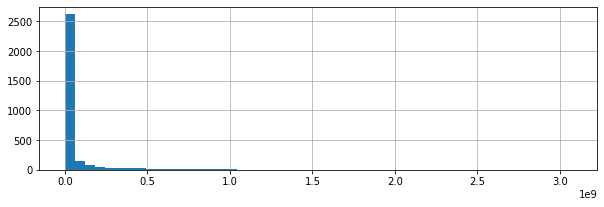

In [21]:
print(data['box_office'].describe())
data['box_office'].hist(bins=50, figsize=(10,3));

In [22]:
#Фильмы с нулевой кассой кажутся ошибкой.
#Возможно, данные о сборах не обновили после создания записи о фильме.
#Стоит от них избавиться (конвертировать нулевой сбор в null)
data.loc[data['box_office'] == 0, ['box_office']] = np.nan

Гистограмма сборов выглядит как одна сплошная аномалия

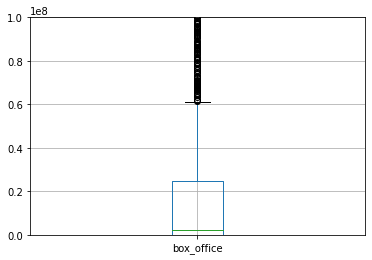

In [23]:
from matplotlib import pyplot as plt
data.boxplot('box_office');
plt.ylim(0, 100000000)
plt.show()

И тут ничего не сделать. Похоже, что большинство картин приносят копейки (или по ним толком не заводят информацию о сборах) и из-за этого блокбастеры выглядят аномалиями. От таких аномалий избавиться не получится - они окажут большое влияние на анализ. Возможно, в анализе придется использовать среднее или сумму, а не медиану.

In [24]:
#но на всякий случай можно проверить фильмы с максимальной и минимальной кассой:
display(data.sort_values('box_office', ascending=False).head())
data.sort_values('box_office').head()

,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
pu_number,,,,,,,,,,,,,,,
111021719,Холоп,2019-12-19 12:00:00,Художественный,"ООО ""МЕМ-МЕДИА"" по заказу АО ""ВБД Груп""",Россия,К.Шипенко,"Э.Илоян, Д.Жалинский, В.Дусмухаметов, Т.Бадзие...",«12+» - для детей старше 12 лет,25000000.0,35000000.0,160000000.0,Фонд кино,6.8,комедия,3.073569e+09
111011817,Движение вверх,2017-12-21 12:00:00,Художественный,"ООО ""Студия ""ТРИТЭ"" Никиты Михалкова""",Россия,А.Мегердичев,"Л.Верещагин, А.Златопольский, Н.Михалков, ООО ...",«6+» - для детей старше 6 лет,0.0,400000000.0,590192191.0,Фонд кино,7.5,"спорт,драма",2.779686e+09
121005519,Мстители: Финал,2019-04-29 12:00:00,Художественный,Марвел Студиос,США,"Джо Руссо, Энтони Руссо",Кевин Фейги,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.6,"фантастика,боевик,драма",2.576614e+09
111024918,Т-34,2018-12-21 12:00:00,Художественный,"ООО ""Кинокомпания МАРС-фильм"" по заказу ООО ""М...",Россия,А.Сидоров,"А.Златопольский, Р.Дишдишян, Л.Блаватник, Н.Яр...",«12+» - для детей старше 12 лет,60000000.0,120000000.0,563784717.0,Фонд кино,6.5,"драма,военный,боевик",2.271754e+09
121009217,Пираты Карибского моря: Мертвецы не рассказыва...,2017-05-17 12:00:00,Художественный,"Джерри Брукхаймер Филмз, Уолт Дисней Пикчерз, ...",США,"Йоаким Реннинг, Эспен Сандберг",Джерри Брукхаймер,«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,6.6,"фэнтези,боевик,комедия",2.118396e+09


,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
pu_number,,,,,,,,,,,,,,,
111006013,Жестокий романс,2013-10-18 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,Э.Рязанов,Неизвестно,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,8.1,"драма,мелодрама,история",40.0
111016714,Каменный цветок.,2014-12-01 12:00:00,Художественный,"Киностудия ""Мосфильм""",СССР,А.Птушко,Неизвестно,«0+» - для любой зрительской аудитории,NaN,NaN,NaN,NaN,7.1,"фэнтези,драма,мелодрама",50.0
121006410,22 пули: Бессмертный,2010-04-01 12:00:00,Художественный,Еуроп Корпорейшн,Франция,Ришар Бери,"Люк Бессон, Дидье Хорау, Пьер-Анж Ле Погам",«16+» - для детей старше 16 лет,NaN,NaN,NaN,NaN,7.1,"боевик,драма,криминал",75.0
121025012,Астерикс и Обеликс в Британии 3D,2012-10-05 12:00:00,Художественный,"Уайлд Банч, Фиделите Фильм, Филм Кайрос, Синет...",Франция-Италия-Испания-Венгрия,Лоран Тирар,"Оливье Делбоск, Марк Миссонье",«6+» - для детей старше 6 лет,NaN,NaN,NaN,NaN,5.6,"комедия,приключения,семейный",80.0
111006113,За спичками,2013-10-18 12:00:00,Художественный,"Киностудия ""Мосфильм"", ""СУОМИ-ФИЛЬМ""","СССР, Финляндия","Л.Гайдай, Р.Орко",Неизвестно,«12+» - для детей старше 12 лет,NaN,NaN,NaN,NaN,7.5,"комедия,приключения,история",100.0


По максимумам все понятно: "Холоп", "Движение вверх" и "Мстители" были хитами.
А с минимумами странно: 'Жестокий романс' собрал 40 рублей. Возможно, для старых фильмов сборы заведены некорректно.

##### Господдержка

,budget,refundable_support,nonrefundable_support
count,3.320000e+02,3.320000e+02,3.320000e+02
mean,1.272297e+08,1.186446e+07,4.898099e+07
std,1.885883e+08,2.491656e+07,5.998012e+07
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.200000e+07,0.000000e+00,2.500000e+07
50%,6.864992e+07,0.000000e+00,3.000000e+07
75%,1.419853e+08,1.500000e+07,4.037500e+07
max,2.305074e+09,1.800000e+08,4.000000e+08


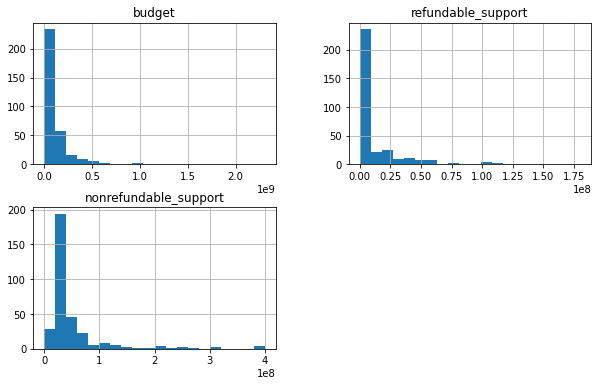

In [25]:
has_support = data['nonrefundable_support'].notna()
display(data[has_support][['budget', 'refundable_support', 'nonrefundable_support']].describe())
data[has_support][['budget', 'refundable_support', 'nonrefundable_support']].hist(bins=20, figsize=(10,6));

In [26]:
#Видно, что встречается нулевой бюджет. Также, следует проверить, что поддержка не превышает бюджет
def bad_budget_filter():
    return (has_support) & (data['budget'] <= (data['refundable_support'] + data['nonrefundable_support']));

titles_with_zero_budget = data[bad_budget_filter()]['title'].unique()
print('Дубликаты среди фильмом с нулевым бюджетом:', data.query('title in @titles_with_zero_budget').duplicated().sum())
data[bad_budget_filter()]

Дубликаты среди фильмом с нулевым бюджетом: 0


,title,show_start_date,type,film_studio,production_country,director,producer,age_restriction,refundable_support,nonrefundable_support,budget,financing_source,ratings,genres,box_office
pu_number,,,,,,,,,,,,,,,
111023614,14+,2014-12-19 12:00:00,Художественный,"ООО Киностудия ""Сентябрь""",Россия,А.Зайцев,"О.Гранина, А.Зайцев",«16+» - для детей старше 16 лет,0.0,23000000.0,0.0,"Министерство культуры, Фонд кино",6.6,мелодрама,1.023402e+07
111000415,Дуxless 2,2015-01-26 12:00:00,Художественный,"ООО ""Киностудия ""Слово"", ООО ""Арт Пикчерс Студия""",Россия,Р.Прыгунов,"П.Ануров, Ф.Бондарчук, Д.Рудовский",«16+» - для детей старше 16 лет,0.0,75000000.0,0.0,Фонд кино,6.6,драма,4.461635e+08
111017315,Воин (2015),2015-09-28 12:00:00,Художественный,"ООО ""Форпост Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,А.Андрианов,"ООО ""Арт Пикчерс Студия""",«12+» - для детей старше 12 лет,10000000.0,70000000.0,0.0,Фонд кино,7.8,"боевик,драма,криминал",1.965724e+08
111009615,Бармен.,2015-05-26 12:00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Штурманова,Т.Вайнштейн,«16+» - для детей старше 16 лет,20000000.0,0.0,0.0,Фонд кино,6.2,"комедия,фэнтези",6.741897e+07
114001715,Савва. Сердце воина,2015-07-21 12:00:00,Анимационный,"ООО ""Глюкоза Продакшн"", ООО ""Арт Пикчерс Студия""",Россия,М.Фадеев,А.Чистяков,«6+» - для детей старше 6 лет,60000000.0,100000000.0,0.0,Фонд кино,4.6,"мультфильм,приключения,фэнтези",1.844876e+08
111010215,Тряпичный союз,2015-06-08 12:00:00,Художественный,"ООО ""Кинокомпания ""КОКТЕБЕЛЬ""",Россия,М.Местецкий,"Р.Борисевич, А.Кушаев",«18+» - запрещено для детей,0.0,59000000.0,0.0,Фонд кино,6.3,"комедия,драма",1.957739e+06
111017115,Срочно выйду замуж,2015-09-30 12:00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,С Чекалов,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",«16+» - для детей старше 16 лет,0.0,35000000.0,0.0,Фонд кино,5.1,"комедия,мелодрама",7.293778e+07
111004916,Помню - не помню!,2016-03-01 12:00:00,Художественный,"ООО ""КиноФирма""",Россия,В.Ровенский,"ООО ""КиноФирма""",«12+» - для детей старше 12 лет,0.0,6000000.0,0.0,Министерство культуры,4.3,комедия,1.536293e+07
111008216,Любовь с ограничениями,2016-04-29 12:00:00,Художественный,"АО ""ВайТ Медиа"", ООО ""Арт Пикчерс Студия""",Россия,Д.Тюрин,"Ф.Бондарчук, Т.Вайнштейн, Д.Рудовский",«16+» - для детей старше 16 лет,19000000.0,51000000.0,0.0,Фонд кино,6.3,"комедия,мелодрама",7.029905e+07


In [27]:
#Всего 17 уникальных строк с нулевым бюджетом. 
#Если найти для них бюджет, то с join'ом проблем не будет
budget_fix_data = { 
    'pu_number': [
        111023614, 
        111000415, 
        111017315, 
        111009615, 
        114001715, 
        111010215, 
        111017115, 
        111004916, 
        111008216, 
        111018116, 
        114001817, 
        111004317, 
        111012117, 
        114001018, 
        114003018, 
        114006518, 
        114002419
    ],
    'title_2': [
        '14+', 
        'Дуxless 2', 
        'Воин (2015)', 
        'Бармен.', 
        'Савва. Сердце воина', 
        'Тряпичный союз', 
        'Срочно выйду замуж', 
        'Помню - не помню!', 
        'Любовь с ограничениями', 
        'Притяжение (2016)', 
        'Чудо-юдо', 
        'Мифы', 
        'Селфи', 
        'Два хвоста', 
        'Принцесса и дракон', 
        'Баба Яга', 
        'Большое путешествие'
    ],
    'budget_manual': [
        30500000,
        140000000,
        91500000,
        60000000,
        1000000000,
        np.NaN,
        85400000,
        87100000,
        110000000,
        380000000,
        105500000,
        50000000,
        140000000,
        110000000,
        116000000,
        220000000,
        188500000
    ]
}
budget_fix = pd.DataFrame(budget_fix_data).set_index('pu_number')
data.loc[bad_budget_filter(), 'budget'] = data.join(budget_fix)['budget_manual']
data[bad_budget_filter()]['budget'].count()

0

Невалидный бюджет удалось исправить через ручной поиск в интернете. Не лучшее решение, но таких проблемных данных было не много.

Кроме того, не удалось найти бюджет одной из картин (Тряпичный союз) - для нее бюджет был конвертирован в пустоту, чтобы не попадал в анализ как ноль. Потому что нулевой бюджет невозможен.

In [28]:
#Можно еще проверить фильмы с поддержкой, но с пустыми сборами:
data[(has_support) & (data['box_office'].isna())][['title']]

,title
pu_number,
111018715,Золотая рыбка (2015)
111001217,Любовь и Сакс
214010116,Колобанга. Только для пользователей Интернета ...
111011917,"Детский юмористический киножурнал ""ЕРАЛАШ"", вы..."
111023518,Зима
111002619,Мальчик русский
111008619,Танец с саблями
111010019,Куратор
112004619,Байкал - Сердце мира 3D


In [29]:
box_office_fix_data = {
    'pu_number': [
        111018715
        , 111001217
        , 214010116
        , 111011917
        , 111023518
        , 111002619
        , 111008619
        , 111010019
        , 112004619
        , 111015519
        , 111018919
        , 111022519
        , 111023019
        , 111023119
    ],
    'title_2': [
        'Золотая рыбка (2015)'
        , 'Любовь и Сакс'
        , 'Колобанга. Только для пользователей Интернета (26 серий)'
        , 'Детский юмористический киножурнал "ЕРАЛАШ", выпуски 312-323'
        , 'Зима'
        , 'Мальчик русский'
        , 'Танец с саблями'
        , 'Куратор'
        , 'Байкал - Сердце мира 3D'
        , 'На Луне'
        , 'Кроличья лапа'
        , 'Вторжение'
        , 'Я свободен'
        , '(Не)идеальный мужчина'
    ],
    'box_office_manual': [
        np.NaN
        , np.NaN
        , np.NaN
        , np.NaN
        , 1413295
        , 1002885
        , 1400974
        , 154830
        , np.NaN
        , 907075
        , 974025
        , 2122228680
        , np.NaN
        , 1024917790
    ]
}

box_office_fix = pd.DataFrame(box_office_fix_data).set_index('pu_number')
data.loc[(has_support) & (data['box_office'].isna()), 'box_office'] = data.join(box_office_fix)['box_office_manual']

Часть недостававших кассовых сборов удалось найти в интернете, но часть так и осталась без сборов - документалистика и цифровые релизы.

#### Шаг 2.6. Добавьте новые столбцы

- Создайте столбец с информацией о годе проката. Выделите год из даты премьеры фильма.

In [30]:
data['show_start_year'] = data['show_start_date'].dt.year

- Создайте два столбца: с именем и фамилией главного режиссёра и основным жанром фильма. В столбцы войдут первые значения из списка режиссёров и жанров соответственно.

<div id="accordion">
    <div class="card">
        <div class="card-header" id="headingThree">
            <button class="btn btn-link collapsed" data-toggle="collapse" data-target="#collapseHint_2" aria-expanded="false" aria-controls="collapseHint_2">Подсказка</button>
        </div>
        <div id="collapseHint_2" class="collapse" aria-labelledby="headingThree" data-parent="#accordion">
            <div class="card-body">
Чтобы создать такие столбцы, лучше всего использовать собственную функцию. Эту функцию можно применить к двум столбцам сразу. 
            </div>
        </div>
    </div>
</div>

In [31]:
data['genre_primary'] = data['genres'].str.split(',').str[0].str.strip()
data['director_primary'] = data['director'].str.split(',').str[0].str.strip()

- Посчитайте, какую долю от общего бюджета фильма составляет государственная поддержка.

In [32]:
data.loc[has_support, 'budget_share'] = (data['nonrefundable_support'] + data['refundable_support']) / data['budget']
data['support'] = data['nonrefundable_support'] + data['refundable_support']

#### Заключение по предобработке
* Было обнаружено и удалено две строки - дубликата по номеру прокатного удостоверения. В теории, их не должно было быть.
* Большой объем данных с очень маленькими кассовыми сборами. Предобработка не проводилась из-за необъяснимости такого явления.
* Часть категориальных данных была пуста. Пустоты были заполнены строкой "Неизвестно".
* В поле 'Type' были значения с пробелами. Исправлено с помощью простого strip().
* Рейтинги картин были предствлены строками в двух форматах - десятичном и процентном. Они были приведены к десятичному формату и конвертированы во float.
* Часть строк содержала нули в качестве бюджета - для таких картин бюджет был вручную найден и заполнен из других источников.

### Шаг 3. Проведите исследовательский анализ данных


- Посмотрите, сколько фильмов выходило в прокат каждый год. Обратите внимание, что данные о прокате в кинотеатрах известны не для всех фильмов. Посчитайте, какую долю составляют фильмы с указанной информацией о прокате в кинотеатрах.

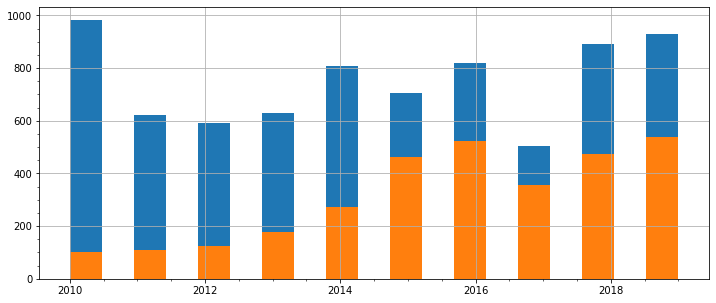

In [33]:
data['show_start_year'].hist(figsize=(12,5), bins=19).minorticks_on();
data[data['box_office'].notna()]['show_start_year'].hist(figsize=(12,5), bins=19).minorticks_on();

В среднем, выход фильмов равномерен по годам (иногда меньше, иногда - больше). А вот доля фильмов в прокате постепенно росла с 2010 и достигла среднего плато в 2015. 

- Изучите, как менялась динамика проката по годам. В каком году сумма сборов была минимальной? А максимальной?

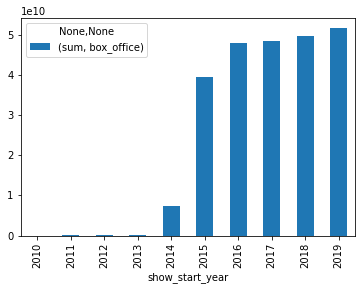

In [34]:
data.pivot_table(index='show_start_year', values='box_office', aggfunc=['sum']).plot(kind='bar');

Минимальная касса - в 2010, максимальная - в 2019. До 2014 касса подозрительно маленькая - возможно, данные до этого не собирались, либо собирались плохо. После 2016 кассовые сборы вышли на плато в 50 млрд. рублей. Маловероятно, что это повторилось в 2020.

- С помощью сводной таблицы посчитайте среднюю и медианную сумму сборов для каждого года.

In [35]:
data.pivot_table(index='show_start_year', values='box_office', aggfunc=['mean', 'median'])

,mean,median
,box_office,box_office
show_start_year,,
2010,2.404608e+04,1710.000
2011,1.293832e+05,3000.000
2012,5.654815e+04,6220.000
2013,1.664788e+05,3580.000
2014,2.727089e+07,20400.000
2015,8.549213e+07,5003450.150
2016,9.117390e+07,3915041.020
2017,1.360328e+08,9968340.000


Интересно, что разница между средним и медианой даже не в разы, а на порядки (вплоть до трех порядков). Это говорит о том, что большая часть кинематографа не пользуется популярностью, а всю кассу собирают отдельные блокбастеры.

- Определите, влияет ли возрастное ограничение аудитории («6+», «12+», «16+», «18+» и т. д.) на сборы фильма в прокате в период с 2015 по 2019 год? Фильмы с каким возрастным ограничением собрали больше всего денег в прокате? Меняется ли картина в зависимости от года? Если да, предположите, с чем это может быть связано.

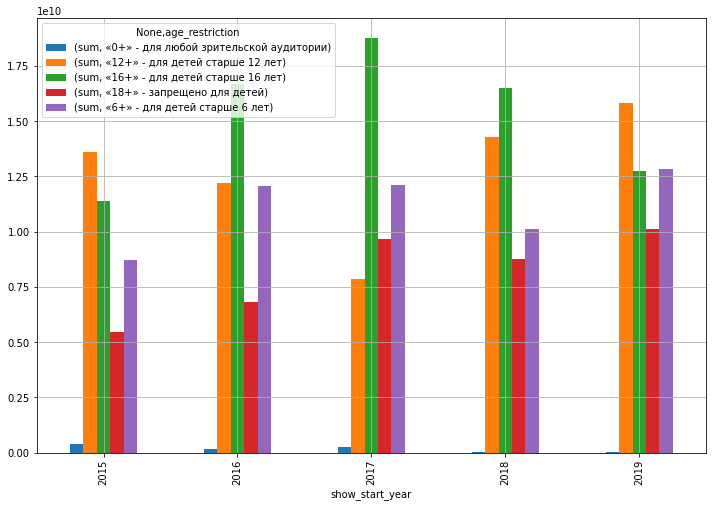

In [36]:
(
    data
    .query('(show_start_year >= 2015) and (show_start_year <= 2019)')
    .pivot_table(index='show_start_year', columns='age_restriction', values='box_office', aggfunc=['sum'])
    .plot(grid=True, figsize=(12, 8), kind='bar')
);

Наибольшую прибыль приносят картины для категорий 16+ и 12+. Наименьшую - 0+. Также, есть проблемы у 18+. По годам соотношение остается примерно одинаковым. Разве что 16+ и 12+ соревнуются за лидерство, а в 2017 у категории 12+ было аномальное падение относительно других категорий.

Объясняется такое распределение просто: подростки - это основные посетители кинотеатров и целевая аудитория современного популярного кинематографа. К тому же современные фильмы 16+ по содержанию очень близки к 18+.

### Шаг 4. Исследуйте фильмы, которые получили государственную поддержку

На этом этапе нет конкретных инструкций и заданий — поищите интересные закономерности в данных. Посмотрите, сколько выделяют средств на поддержку кино. Проверьте, хорошо ли окупаются такие фильмы, какой у них рейтинг.

#### Динамика поддержки

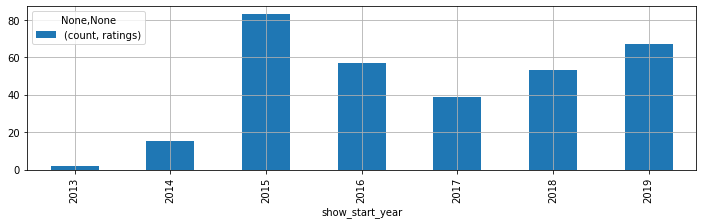

In [37]:
(
    data[has_support]
    .pivot_table(index='show_start_year', values='ratings', aggfunc=['count'])
    .plot(grid=True, figsize=(12, 3), kind='bar')
);

В 2013 поддержку получили единицы. А в 2014 - уже под 20 картин финансировались госудраством. После 2015 поддержка выравнялась примерно на уровне 60 фильмов.

#### Динамика рейтинга

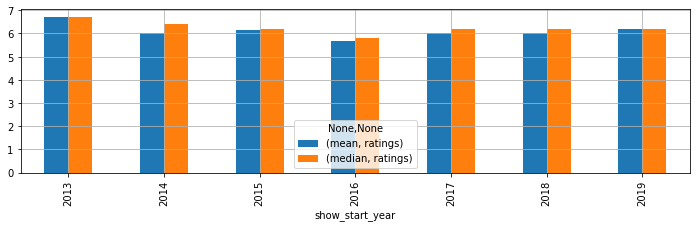

In [38]:
(
    data[has_support]
    .pivot_table(index='show_start_year', values='ratings', aggfunc=['mean', 'median'])
    .plot(grid=True, figsize=(12, 3), kind='bar')
);

В среднем, рейтинг для поддерживаемых фильмов никак не меняется - держится в районе 6 баллов. Много это или мало - можно определеить, сравнив со общим средним рейтингом.

In [39]:
data['ratings'].mean()

6.487862513426424

В среднем для фильмов рейтинг находится в районе 6,5. Это не намного больше поддерживаемых.

#### Динамика окупаемости

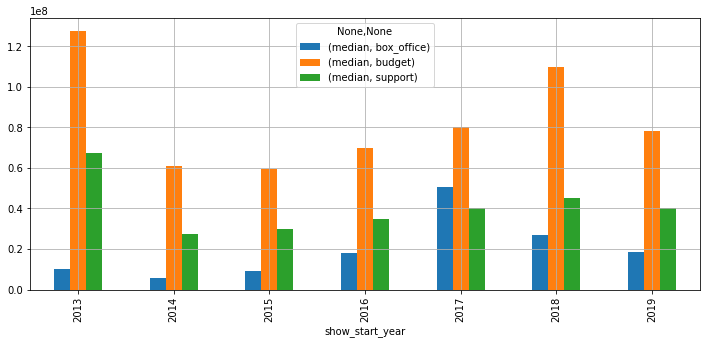

In [40]:
(
    data[has_support]
    .pivot_table(index='show_start_year', values=['box_office', 'support', 'budget'], aggfunc=['median'])
    .plot(grid=True, figsize=(12, 5), kind='bar')
);

Если судить по медиане, то поддерживаемые фильмы никак не окупаются и не могут отбить даже государственные деньги. Также, по графику видно, что обычно государство выделяет до половины бюджета картины.

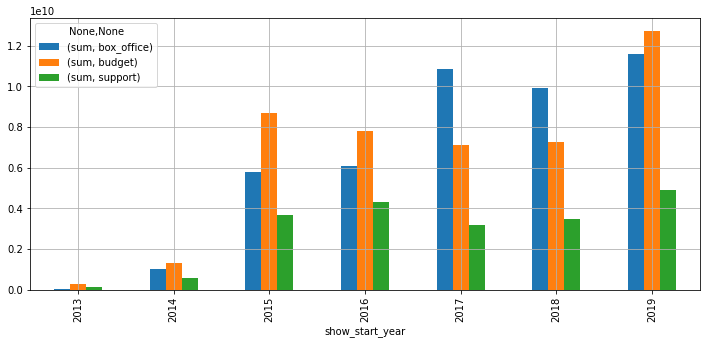

In [41]:
(
    data[has_support]
    .pivot_table(index='show_start_year', values=['box_office', 'support', 'budget'], aggfunc=['sum'])
    .plot(grid=True, figsize=(12, 5), kind='bar')
);

А вот если сравнивать суммарные значения, то ситуация кажется гораздо лучше - из кассы можно было бы даже вернуть государственные деньги. В 2017 и 2018 картины смогли окупить и свой бюджет. Это при том, что господдержка остается примерно на одном уровне.

По этим двум графикам можно сказать, что большинство картин не окупаются (видно по медианам). Но "работа по площадям" все равно дает свои плоды и рано или поздно появляются хиты, приносящие прибыль.

#### Динамика окупаемости по возрастам

In [42]:
def draw_for_age(age):
    (
        data[(has_support) & (data['age_restriction'] == age)]
        .pivot_table(index='show_start_year', values=['box_office', 'budget'], aggfunc=['sum'])
        .plot(grid=True, figsize=(12, 3), kind='bar', title=age)
    );

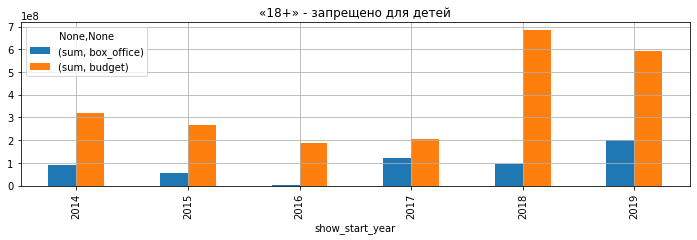

In [43]:
draw_for_age('«18+» - запрещено для детей')

Фильмы 18+ стабильно не отбиваются. И зарабатывают копейки. Не наша возрастная категория.

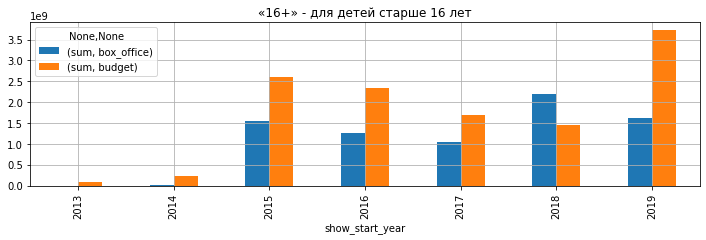

In [44]:
draw_for_age('«16+» - для детей старше 16 лет')

Уже лучше. Стабильные кассовые сборы начиная с 2015. Хотя суммарный бюджет отбился только в 2018.

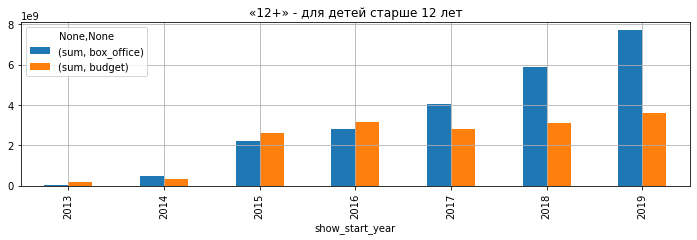

In [45]:
draw_for_age('«12+» - для детей старше 12 лет')

Эта категория показывала стабильный рост по сборам при сохранении затрат. И суммарные затраты.

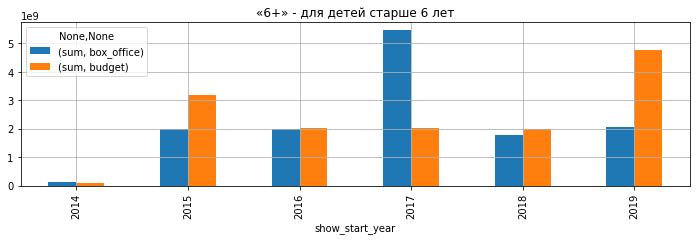

In [46]:
draw_for_age('«6+» - для детей старше 6 лет')

В категории 6+ тоже стабильная касса, хотя общий бюджет отбился только в 2017.

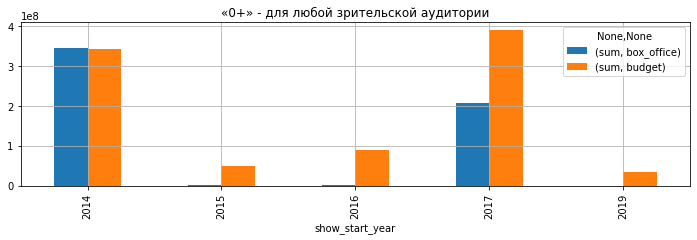

In [47]:
 draw_for_age('«0+» - для любой зрительской аудитории')

В категории 0+ суммарный бюджет отбивается через раз.

#### Динамика выхода по возрастам

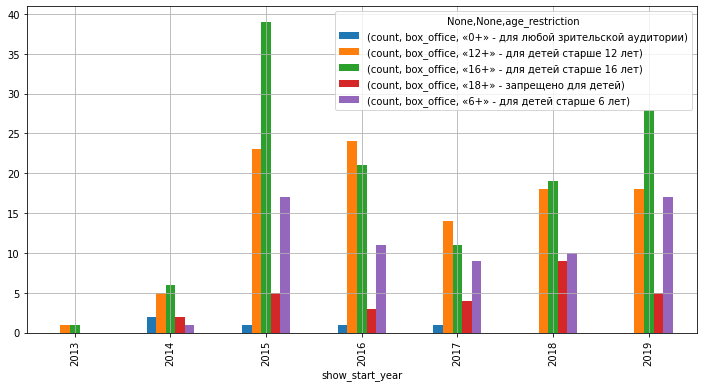

In [48]:
(
    data[(has_support) ]
        .pivot_table(index='show_start_year', columns='age_restriction', values=['box_office'], aggfunc=['count'])
        .plot(grid=True, figsize=(12, 6), kind='bar')
);

Не смотря на постоянные неудачи в категории 16+, они все еще составляют основную массу продукции.

### Шаг 5. Напишите общий вывод

#### Проблемы при предобработке:
* Было обнаружено и удалено два дубликата по номеру прокатного удостоверения. В теории, их не должно было быть - похоже на ошибку в данных системы.
* Большой объем данных с очень маленькими кассовыми сборами - тоже похоже на некорректные данные.
* Часть категориальных данных была пуста. Но не может быть фильма без режиссера или жанра - явные ошибки в исходных данных, требующие исправления в системе.
* В поле 'Type' были значения с пробелами - это значит, что для заполения этого поля не используется справочник, либо в справочнике есть дубликаты.
* Потребовалось привести рейтинги к одной форме.
* Часть строк содержала нули в качестве бюджета - явная ошибка в исходных данных.


#### Вывод по анализу

* Большинство картин приносит относительно небольшую кассу, а основную массу денег собирают блокбастеры.
* Наибольшую кассу приносят картины в категориях 6+, 12+, 16+.
* Средний рейтинг картин - 6.5 баллов. Для поддерживаемых фильмов этот рейтинг равен 6 баллам.

Эти выводы нашли отражение и в фильмах с господдержкой:
* Средняя поддерживаемая картина не может отбить свой бюджет. Эта ситуация с годами никак не меняется. 
* В динамике виден общий рост кассовых сборов поддерживаемых фильмов при сохранении объема поддержки. Это говорит об увеличении частоты появления хитов, способных не только отбить бюджет, но и принести прибыль (это никак не относиться к большинству картин).
* Поддержка фильмов 18+ не показывает никакой положительной динамики. Скорее наоборот.
* Наибольшую эффективность показывает поддержка картин для подростков 12+. Также, относительно не плохо показывают себя фильмы для детей 0+ и 6+.